In [12]:
from  matplotlib import pyplot as plt 
import numpy as np 
from scipy import ndimage as ndim 

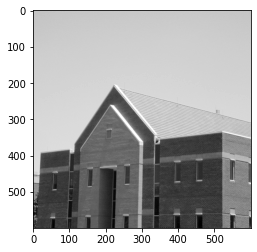

In [13]:
f = plt.imread("./../images/building-600by600.tif")
plt.imshow(f , "gray")

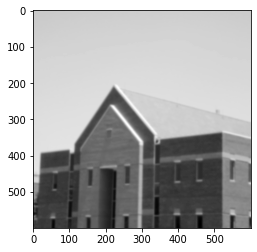

In [14]:
# Gauss Filter 
f = f.copy()
g = ndim.gaussian_filter(f,sigma= 2)

plt.imshow(g,"gray")

In [15]:
# 计算 x,y方向上的梯度
def gradient(f):
    h,w = f.shape 
    gradient_x_kernel = np.array ([
    [
        -1, - 1, -1
    ],[
        0,0,0
    ],[
        1,1,1
    ]])
    gradient_x = ndim.convolve(f,gradient_x_kernel,mode ="constant")

    gradient_y_kernel = np.array([
    [
        -1 , 0 , 1
    ],[
        -2 , 0 , 2
    ],[
        -1, 0 , 1
    ]
    ])

    gradient_y =  ndim.convolve(f,gradient_y_kernel , mode="constant")
    return gradient_x , gradient_y

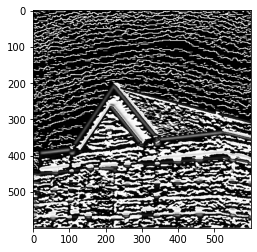

In [16]:
gx, gy = gradient(g)
plt.imshow(gx , 'gray')

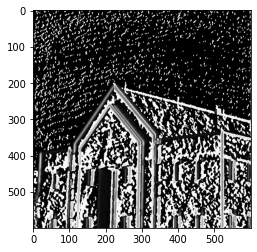

In [17]:
plt.imshow(gy , "gray")

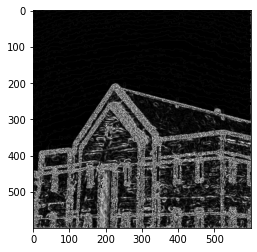

In [18]:
# 幅度图
def magnitude(gx , gy):   
    m = gx ** 2 + gy ** 2
    return m 
m = magnitude(gx , gy)
m = m / m.max() * 255
plt.imshow(m , "gray")

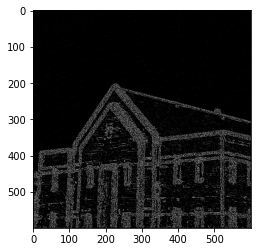

In [19]:

"""
tan 算出梯度方向
"""
def direction (gx,gy):
    
    return np.arctan2(gx,gy)

# 非极大化抑制    
def non_max_suppression(m , d):
    h,w = m.shape 
    res = np.zeros([h,w])    
    piece = np.pi / 8
    for y in range(1,h-1):
        for x in range(1,w-1):
            theta = d[y][x]
            current  = m[y][x]
            before = 0 
            after = 0             
            if 0 <= theta < piece or 6 * piece <= theta < np.pi:
                before = m[y][x -1 ]
                after = m[y][x + 1]
            if piece <= theta < piece * 3:
                before = m[ y + 1] [x - 1]
                after = m[y-1][x + 1]
            if piece * 3 <= theta < piece  * 5:
                before = m[y-1][x]
                after = m [y+1][x]
            if  5 * piece <= theta < 7 * piece:
                before = m[y-1][x-1]
                after = m[y+1][x+1]

            if current > after and current > before:
                 res[y][x] = current
            else : 
                res[y][x] = 0
    return res

d = direction(gx,  gy)

nm = non_max_suppression(m,d)
plt.imshow(nm , "gray")

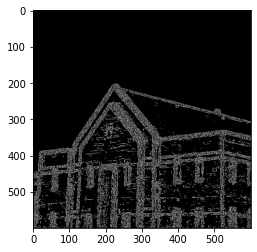

In [24]:
## 双门限处理
def threshold(g , low_threshold_ratio = 0.05 , high_threshold_radio = 0.09):
    high_threshold = g.max() * high_threshold_radio
    low_threshold = high_threshold * low_threshold_ratio

    res = np.zeros(g.shape)

    weak = 25 
    strong = 255 

    strong_y , strong_x = np.where(g > high_threshold)
    zeros_y , zeros_x = np.where(g < low_threshold)

    weak_y , weak_x = np.where((g <= high_threshold) & (g>=low_threshold))

    res[strong_y,strong_x] = strong
    res[weak_y , weak_x] = weak

    return res 

res = threshold(nm , low_threshold_ratio = 0.5 , high_threshold_radio=0.3)

plt.imshow(res,"gray" )
